In [1]:
%load_ext autoreload
%autoreload 2

from circuit_breaking.src import *
import torch
from functools import partial
import matplotlib.pyplot as plt
import numpy as np
import os
from circuit_breaking.src.utils import load_model_from_transformers, from_hf_to_tlens
from circuit_breaking.src.masks import MLPHiddenMask
from tqdm.auto import tqdm
#torch.autograd.set_detect_anomaly(True) 
import pandas as pd


In [2]:
from transformers import GPT2Tokenizer, GPTNeoXTokenizerFast, AutoModelForCausalLM, AutoTokenizer
model_name_or_path = "google/gemma-7b"
model_type = "gemma"

tokenizer = AutoTokenizer.from_pretrained("google/gemma-7b")
tokenizer.pad_token_id = tokenizer.eos_token_id
tokenizer.padding_side = "right"

n_layers = 28
n_heads = 16

print(torch.cuda.memory_allocated() / 1024**3)

0.0


## Load Data

In [3]:
# localization_types = ["localized_ap", "localized_ct", "random", "manual_interp", "all_mlps", "nonlocalized"]
# run_ids = [2]

# # inject_sport = "golf"
# inject_sport = None
# # forget_sport = "basketball"
# forget_sport = None
# # forget_athletes = None
# forget_athletes = 16

# last_epoch = 49

# for run_id in run_ids:
#     for localization_type in localization_types:
#         if forget_sport is not None:
#             if inject_sport is not None:
#                 save_dir = f"results2/localized_finetuning_{inject_sport=}_{forget_sport=}/{localization_type}"
#             else:
#                 save_dir = f"results2/localized_finetuning_{forget_sport=}/{localization_type}"
#         else:
#             if inject_sport is not None:
#                 save_dir = f"results2/localized_finetuning_injection_{inject_sport=}_{forget_athletes=}/{localization_type}"
#             else:
#                 save_dir = f"results2/localized_finetuning_{forget_athletes=}/{localization_type}"

#         if run_id is not None:
#             save_dir = f"{save_dir}_{run_id}"

#         print(save_dir)
#         with open(f"{save_dir}/models/gemma_{localization_type}_combine_heads=True_beta=3_unlearn_{forget_sport=}_{forget_athletes=}_metrics.pkl", 'rb') as f:
#             train_metrics = pickle.load(f)
#         with open(f"{save_dir}/results/probes_gemma_combine_heads=True_beta=3_unlearn_{forget_sport=}_{forget_athletes=}.pkl", 'rb') as f:
#             probe_metrics = pickle.load(f)
#         with open(f"{save_dir}/results/relearning_n_relearn_athletes=2_n_relearn_iters=10_gemma_combine_heads=True_beta=3_unlearn_{forget_sport=}_{forget_athletes=}_results.pkl", 'rb') as f:
#             relearning_metrics = pickle.load(f)
#         with open(f"{save_dir}/full_capability_dict.pkl", 'rb') as f:
#             mmlu_metrics = pickle.load(f)

#         test_loses = {task: train_metrics["test_losses"][task][-1] for task in train_metrics["test_losses"].keys()}
#         # print(test_loses) # keys: task_name, values: value
#         # print(train_metrics["adversarial_evals"][last_epoch]) # key: 'Normal' or 'MC', with sub-dictionaries as values with keys: 'forget', 'maintain'

#         # # key: one for every layer (28 layers)
#         # print(probe_metrics['all_forget_accs'][localization_type])
#         # print(probe_metrics['all_maintain_accs'][localization_type])

#         # print(relearning_metrics['relearning_test_results'][localization_type]) # list of len 10 that contains test results at every step, each test result is a dictionary

#         # print(mmlu_metrics["results"]['mmlu']['acc,none']) # just an int
#         # print()

In [4]:
import pickle
import pandas as pd

localization_types = ["localized_ap", "localized_ct", "random", "manual_interp", "all_mlps", "nonlocalized"]
run_ids = [2, 3, 4]

# inject_sport = "golf"
inject_sport = None
forget_sport = "basketball"
# forget_sport = None
forget_athletes = None
# forget_athletes = 16

last_epoch = 49

# Initialize lists to hold the data
test_losses_list = []
adversarial_evals_list = []
forget_accs_list = []
maintain_accs_list = []
relearning_results_list = []
mmlu_acc_list = []

for run_id in run_ids:
    for localization_type in localization_types:
        if forget_sport is not None:
            if inject_sport is not None:
                save_dir = f"results2/localized_finetuning_{inject_sport=}_{forget_sport=}/{localization_type}"
            else:
                save_dir = f"results2/localized_finetuning_{forget_sport=}/{localization_type}"
        else:
            if inject_sport is not None:
                save_dir = f"results2/localized_finetuning_injection_{inject_sport=}_{forget_athletes=}/{localization_type}"
            else:
                save_dir = f"results2/localized_finetuning_{forget_athletes=}/{localization_type}"

        if run_id is not None:
            save_dir = f"{save_dir}_{run_id}"

        with open(f"{save_dir}/models/gemma_{localization_type}_combine_heads=True_beta=3_unlearn_{forget_sport=}_{forget_athletes=}_metrics.pkl", 'rb') as f:
            train_metrics = pickle.load(f)
        with open(f"{save_dir}/results/probes_gemma_combine_heads=True_beta=3_unlearn_{forget_sport=}_{forget_athletes=}.pkl", 'rb') as f:
            probe_metrics = pickle.load(f)
        with open(f"{save_dir}/results/relearning_n_relearn_athletes=2_n_relearn_iters=10_gemma_combine_heads=True_beta=3_unlearn_{forget_sport=}_{forget_athletes=}_results.pkl", 'rb') as f:
            relearning_metrics = pickle.load(f)
        with open(f"{save_dir}/full_capability_dict.pkl", 'rb') as f:
            mmlu_metrics = pickle.load(f)

        # Collect test losses
        for task, value in train_metrics["test_losses"].items():
            test_losses_list.append({
                'localization_type': localization_type,
                'run_id': run_id,
                'task_name': task,
                'test_loss': value[-1]
            })

        # Collect adversarial evaluations
        for eval_type, results in train_metrics["adversarial_evals"][last_epoch].items():
            adversarial_evals_list.append({
                'localization_type': localization_type,
                'run_id': run_id,
                'eval_type': eval_type,
                'forget': results['forget'],
                'maintain': results['maintain']
            })

        # Collect forget accuracy
        for layer, acc in probe_metrics['all_forget_accs'][localization_type].items():
            forget_accs_list.append({
                'localization_type': localization_type,
                'run_id': run_id,
                'layer': layer,
                'forget_acc': acc
            })

        # Collect maintain accuracy
        for layer, acc in probe_metrics['all_maintain_accs'][localization_type].items():
            maintain_accs_list.append({
                'localization_type': localization_type,
                'run_id': run_id,
                'layer': layer,
                'maintain_acc': acc
            })

        # Collect relearning test results
        for step, results in enumerate(relearning_metrics['relearning_test_results'][localization_type]):
            relearning_results_list.append({
                'localization_type': localization_type,
                'run_id': run_id,
                'step': step,
                'mmlu': results['MMLU'],
                'forget': results['adversarial']['Normal']['forget'],
                'maintain': results['adversarial']['Normal']['maintain'],
                'mc_forget': results['adversarial']['MC']['forget'],
                'mc_maintain': results['adversarial']['MC']['maintain'],
            })

        # Collect MMLU accuracy
        mmlu_acc_list.append({
            'localization_type': localization_type,
            'run_id': run_id,
            'mmlu_acc': mmlu_metrics["results"]['mmlu']['acc,none']
        })

# Convert lists to DataFrames
test_losses_df = pd.DataFrame(test_losses_list)
adversarial_evals_df = pd.DataFrame(adversarial_evals_list)
probe_forget_accs_df = pd.DataFrame(forget_accs_list)
probe_maintain_accs_df = pd.DataFrame(maintain_accs_list)
relearning_results_df = pd.DataFrame(relearning_results_list)
mmlu_acc_df = pd.DataFrame(mmlu_acc_list)

# Display the dataframes to the user
display(test_losses_df)
display(adversarial_evals_df)
display(probe_forget_accs_df)
display(probe_maintain_accs_df)
display(relearning_results_df)
display(mmlu_acc_df)

,localization_type,run_id,task_name,test_loss
0,localized_ap,2,induction,5.189394e-01
1,localized_ap,2,induction_accuracy,1.000000e+00
2,localized_ap,2,pile,2.292100e+00
3,localized_ap,2,pile_accuracy,5.272458e-01
4,localized_ap,2,forget_sport,1.236720e+01
...,...,...,...,...
139,nonlocalized,4,pile_accuracy,5.301061e-01
140,nonlocalized,4,forget_sport,1.475949e+01
141,nonlocalized,4,forget_sport_accuracy,4.526143e-07
142,nonlocalized,4,maintain_sport,8.587590e-02


,localization_type,run_id,eval_type,forget,maintain
0,localized_ap,2,Normal,2.621905e-05,0.999922
1,localized_ap,2,MC,8.778672e-01,0.962814
2,localized_ct,2,Normal,8.634617e-03,0.999931
3,localized_ct,2,MC,8.509621e-01,0.965476
4,random,2,Normal,3.152127e-05,0.997132
5,random,2,MC,4.182897e-01,0.699077
6,manual_interp,2,Normal,5.949422e-04,0.999052
7,manual_interp,2,MC,8.132356e-03,0.984628
8,all_mlps,2,Normal,2.051187e-06,0.999420
9,all_mlps,2,MC,2.160879e-01,0.489265


,localization_type,run_id,layer,forget_acc
0,localized_ap,2,0,0.000000
1,localized_ap,2,1,0.020202
2,localized_ap,2,2,0.050505
3,localized_ap,2,3,0.060606
4,localized_ap,2,4,0.121212
...,...,...,...,...
499,nonlocalized,4,23,0.969697
500,nonlocalized,4,24,0.969697
501,nonlocalized,4,25,0.969697
502,nonlocalized,4,26,0.959596


,localization_type,run_id,layer,maintain_acc
0,localized_ap,2,0,0.009302
1,localized_ap,2,1,0.041860
2,localized_ap,2,2,0.116279
3,localized_ap,2,3,0.106977
4,localized_ap,2,4,0.302326
...,...,...,...,...
499,nonlocalized,4,23,0.953488
500,nonlocalized,4,24,0.958140
501,nonlocalized,4,25,0.958140
502,nonlocalized,4,26,0.944186


,localization_type,run_id,step,mmlu,forget,maintain,mc_forget,mc_maintain
0,localized_ap,2,0,0.56,0.001050,0.999972,0.856186,0.954814
1,localized_ap,2,1,0.57,0.111396,0.999986,0.838102,0.940627
2,localized_ap,2,2,0.55,0.627493,0.999993,0.831273,0.935197
3,localized_ap,2,3,0.58,0.889270,0.999995,0.829170,0.929634
4,localized_ap,2,4,0.56,0.950713,0.999995,0.813827,0.929339
...,...,...,...,...,...,...,...,...
175,nonlocalized,4,5,0.52,0.321869,0.614102,0.274671,0.226745
176,nonlocalized,4,6,0.57,0.198255,0.697826,0.252490,0.231083
177,nonlocalized,4,7,0.55,0.159950,0.723341,0.252394,0.238598
178,nonlocalized,4,8,0.54,0.144068,0.754473,0.264395,0.228408


,localization_type,run_id,mmlu_acc
0,localized_ap,2,0.611095
1,localized_ct,2,0.614727
2,random,2,0.620068
3,manual_interp,2,0.612377
4,all_mlps,2,0.572710
5,nonlocalized,2,0.592081
6,localized_ap,3,0.613873
7,localized_ct,3,0.610810
8,random,3,0.616864
9,manual_interp,3,0.612306


## Make Graphs

### General Performance (tables)

In [ ]:
from scipy.stats import sem

# Perform the groupby operations
forget_sport_accuracy = test_losses_df.query("task_name == 'forget_sport_accuracy'").groupby("localization_type")['test_loss'].mean()
maintain_sport_accuracy = test_losses_df.query("task_name == 'maintain_sport_accuracy'").groupby("localization_type")['test_loss'].mean()
mmlu_acc_mean = mmlu_acc_df.groupby("localization_type")['mmlu_acc'].mean()
mmlu_acc_sem = mmlu_acc_df.groupby("localization_type")['mmlu_acc'].apply(sem) * (mmlu_acc_df.groupby("localization_type")["mmlu_acc"].count() - 1)
mc_forget_mean = adversarial_evals_df.query("eval_type == 'MC'").groupby("localization_type")['forget'].mean()

# Concatenate the results into one DataFrame
combined_df = pd.concat([forget_sport_accuracy, maintain_sport_accuracy, mmlu_acc_mean, mmlu_acc_sem, mc_forget_mean], axis=1)
combined_df.columns = ['forget_sport_accuracy', 'maintain_sport_accuracy', 'mmlu_acc_mean', 'mmlu_acc_se', 'mc_forget_mean']

# Display the combined DataFrame
display(combined_df)

,forget_sport_accuracy,maintain_sport_accuracy,mmlu_acc_mean,mmlu_acc_sem,mc_forget_mean
localization_type,,,,,
all_mlps,0.000001,0.995009,0.590799,0.018089,0.204724
localized_ap,0.000009,0.999921,0.612211,0.001694,0.881280
localized_ct,0.000437,0.999961,0.612377,0.002393,0.864438
manual_interp,0.000073,0.999996,0.611594,0.001496,0.016913
nonlocalized,0.000008,0.957507,0.593553,0.003087,0.233652
random,0.000166,0.999153,0.615178,0.006831,0.486402


### Plot Probes

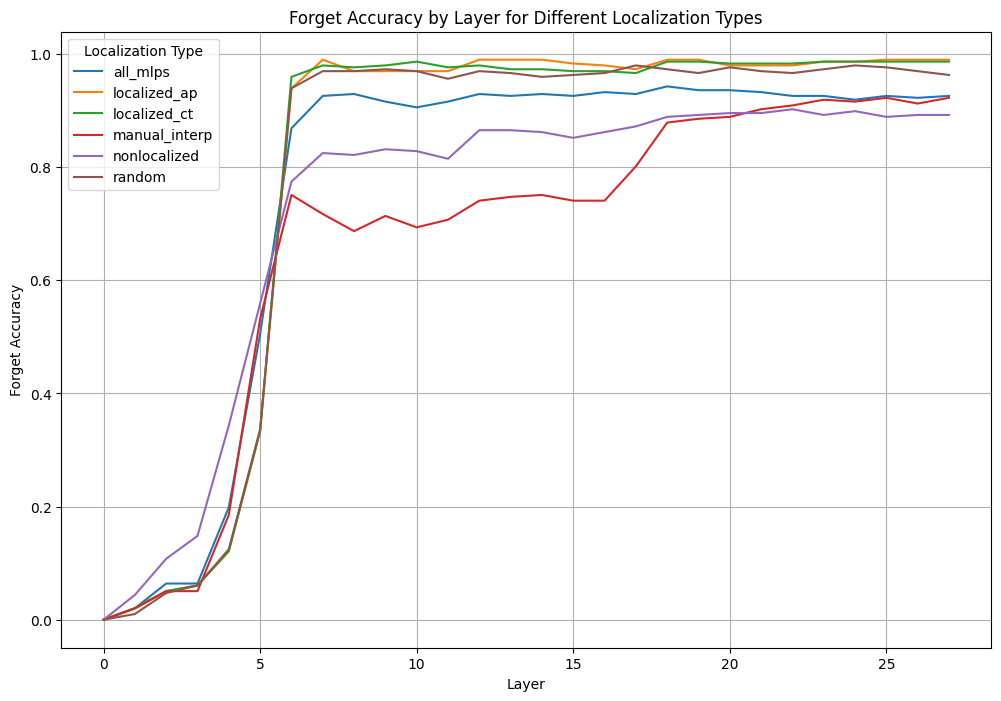

In [6]:
import matplotlib.pyplot as plt

# Group by localization_type and layer, then calculate the mean forget_acc
mean_forget_accs = probe_forget_accs_df.groupby(["localization_type", "layer"])['forget_acc'].mean().unstack()

# Plotting
plt.figure(figsize=(12, 8))
for localization_type in mean_forget_accs.index:
    plt.plot(mean_forget_accs.columns, mean_forget_accs.loc[localization_type], label=localization_type)

plt.xlabel('Layer')
plt.ylabel('Forget Accuracy')
plt.title('Forget Accuracy by Layer for Different Localization Types')
plt.legend(title='Localization Type')
plt.grid(True)
plt.show()

### Plot Relearning

In [7]:
relearning_results_df.query("localization_type == 'manual_interp'")

,localization_type,run_id,step,mmlu,forget,maintain,mc_forget,mc_maintain
30,manual_interp,2,0,0.59,0.006638,0.994808,0.013062,0.981851
31,manual_interp,2,1,0.57,0.097037,0.905051,0.018963,0.975958
32,manual_interp,2,2,0.61,0.090760,0.906282,0.023227,0.970780
33,manual_interp,2,3,0.60,0.069115,0.913376,0.036133,0.962124
34,manual_interp,2,4,0.54,0.056812,0.956710,0.030404,0.963943
35,manual_interp,2,5,0.58,0.050522,0.971408,0.029785,0.969456
36,manual_interp,2,6,0.57,0.050264,0.982999,0.025692,0.969379
37,manual_interp,2,7,0.58,0.049383,0.985801,0.028230,0.969317
38,manual_interp,2,8,0.59,0.090563,0.988109,0.049627,0.970377
39,manual_interp,2,9,0.58,0.061414,0.986625,0.032940,0.968882


/tmp/ipykernel_2298857/4174361530.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_relearning_results_df = pd.concat([relearning_results_df, new_rows], ignore_index=True)


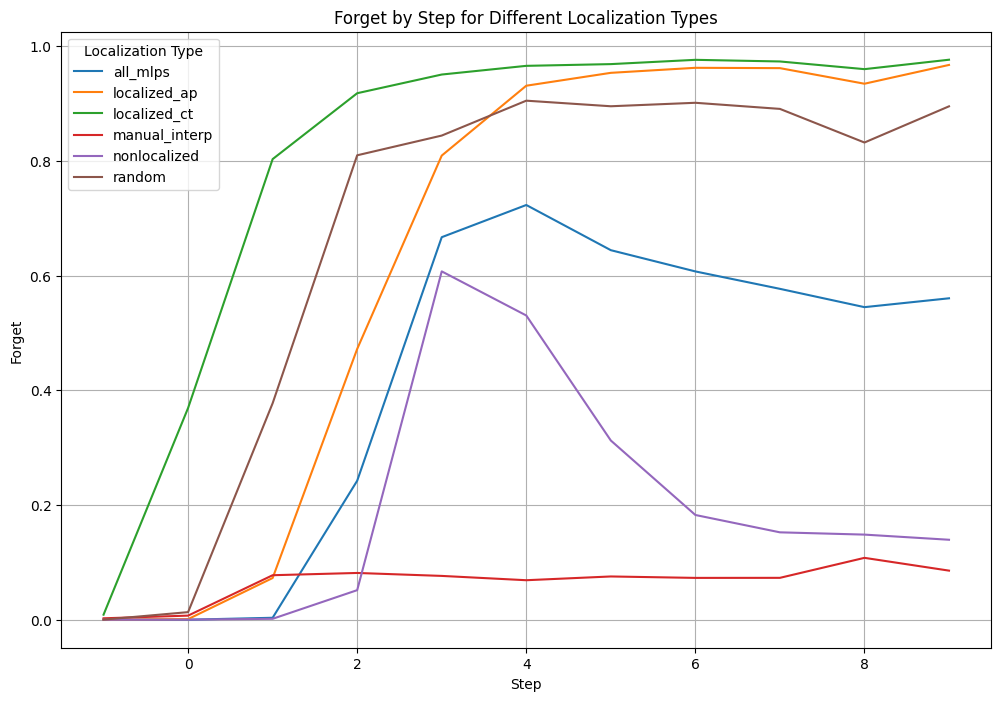

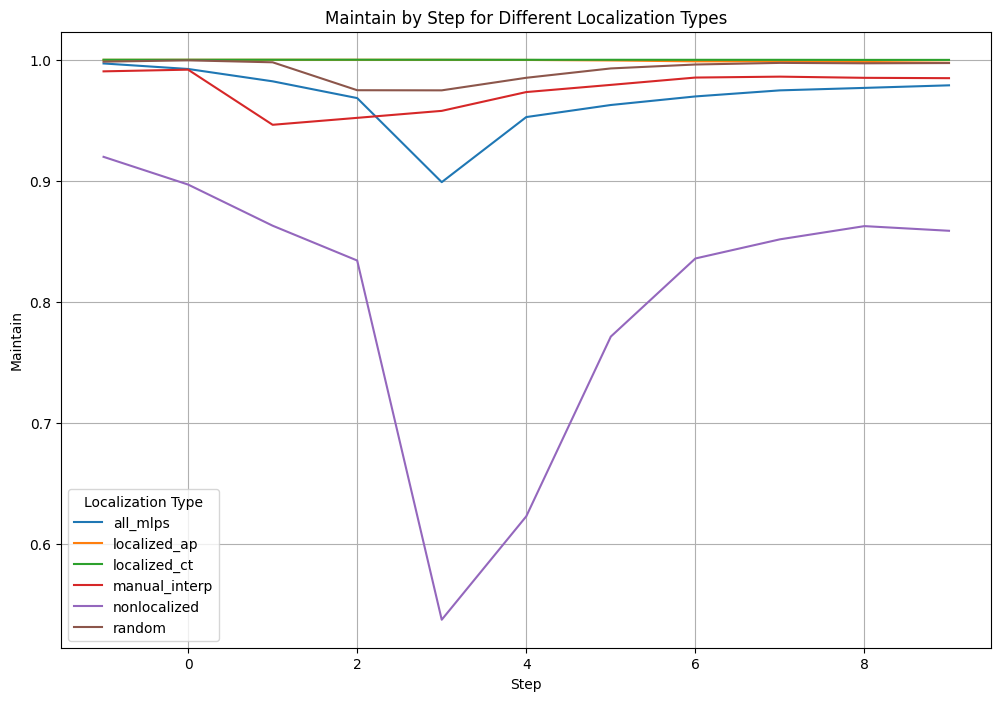

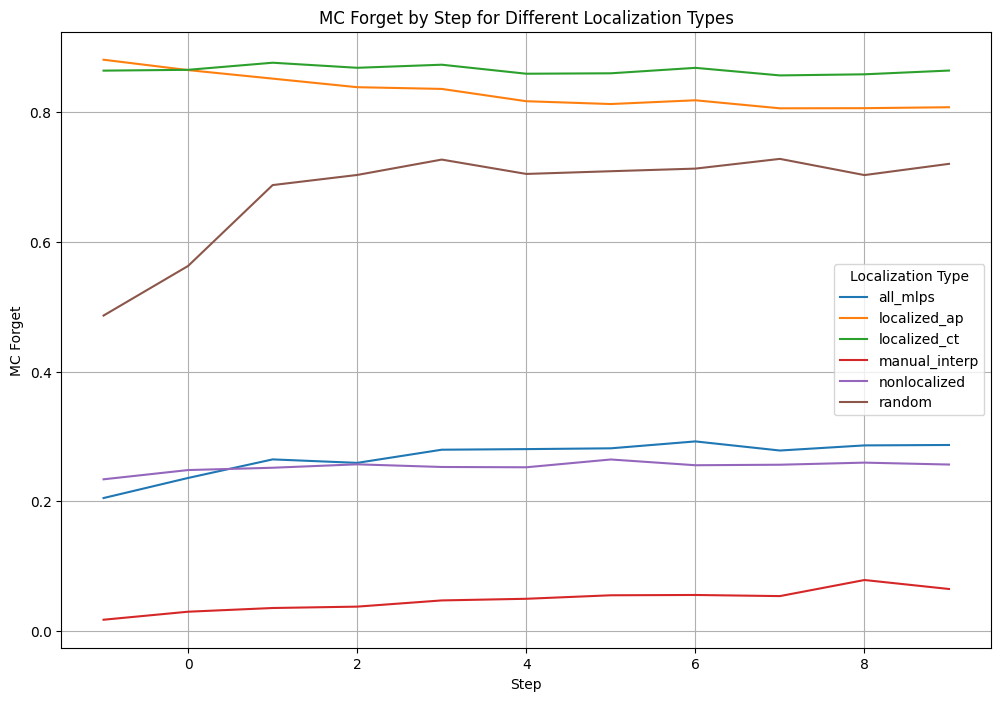

In [8]:
import pandas as pd

# Merge the adversarial_evals_df to get the required columns
merged_df = adversarial_evals_df.pivot(index=['localization_type', 'run_id'], columns='eval_type', values=['forget', 'maintain']).reset_index()
merged_df.columns = ['localization_type', 'run_id', 'forget_MC', 'forget_Normal', 'maintain_MC', 'maintain_Normal']

# Create new rows with step = -1
new_rows = merged_df.copy()
new_rows['step'] = -1
new_rows['mmlu'] = None  # Leave mmlu blank
new_rows = new_rows.rename(columns={
    'forget_Normal': 'forget',
    'maintain_Normal': 'maintain',
    'forget_MC': 'mc_forget',
    'maintain_MC': 'mc_maintain'
})

# Select and reorder the columns to match relearning_results_df
new_rows = new_rows[['localization_type', 'run_id', 'step', 'mmlu', 'forget', 'maintain', 'mc_forget', 'mc_maintain']]

# Append the new rows to relearning_results_df
combined_relearning_results_df = pd.concat([relearning_results_df, new_rows], ignore_index=True)

# Display the updated DataFrame
# display(combined_relearning_results_df)

import matplotlib.pyplot as plt

# Group by localization_type and step, then calculate the mean for each metric
mean_metrics = combined_relearning_results_df.groupby(['localization_type', 'step']).mean().reset_index()

# Plotting function
def plot_metric(metric, ylabel):
    plt.figure(figsize=(12, 8))
    for localization_type in mean_metrics['localization_type'].unique():
        subset = mean_metrics[mean_metrics['localization_type'] == localization_type]
        plt.plot(subset['step'], subset[metric], label=localization_type)
    plt.xlabel('Step')
    plt.ylabel(ylabel)
    plt.title(f'{ylabel} by Step for Different Localization Types')
    plt.legend(title='Localization Type')
    plt.grid(True)
    plt.show()

# Plot forget
plot_metric('forget', 'Forget')

# Plot maintain
plot_metric('maintain', 'Maintain')

# Plot mc_forget
plot_metric('mc_forget', 'MC Forget')

# Plot mc_maintain
# plot_metric('mc_maintain', 'MC Maintain')